In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from sklearn import svm, cross_validation
import pylab as pl
from PIL import Image
import numpy as np
import os

/usr/local/lib/python2.7/dist-packages/matplotlib-1.4.3-py2.7-linux-x86_64.egg/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Make sure that caffe is on the python path:
caffe_root = '/u/zexuan/caffe/caffe/'  # this file is expected to be in {caffe_root}/examples
caffe_real_root = '/pkgs/caffe/'
thesis_root = '/ais/gobi2/pingpong/thesis/'
#!ls /pkgs/caffe
import sys
sys.path.insert(0, caffe_real_root + 'python')
import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

if not os.path.isfile('~/caffe/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !~/caffe/caffe/scripts/download_model_binary.py ~/caffe/caffe/models/bvlc_reference_caffenet

Model already exists.


In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()

In [4]:
import skimage
import skimage.io
import time

start_time = time.time()
container_path = 'output_labeled_img_dir_5videos_for_pt/'

training_set = {}
training_set['data'] = []
training_set['target'] = []

pt_folders = [f for f in sorted(os.listdir(container_path)) if os.path.isdir(os.path.join(container_path, f))]
#print 'folders: ', pt_folders
#for pt_folder in pt_folders:
pt_index = 1
pt_folder = pt_folders[pt_index]
pt_folder_path = os.path.join(container_path, pt_folder)
documents = [os.path.join(pt_folder_path, d) for d in sorted(os.listdir(pt_folder_path))]
pt_data = []
pt_target = []
frame_class_tuple = []
#print documents
for pic in documents:
    pic_basename_lower = os.path.basename(pic).lower()
    if not pic_basename_lower.endswith('png'):
        if pic_basename_lower == 'a_label.txt':
            with open(pic) as f:
                for line in f:
                    line = line.strip()
                    if len(line) == 0 or line[0] == "#":
                        continue
                    frames = line.split(':')
                    assert(len(frames)==3)
                    frames[0] = int(frames[0])
                    frames[1] = int(frames[1])
                    output_class = frames[2]
                    frame_class_tuple.append((frames[0], frames[1], output_class))
        continue

    img = skimage.img_as_float(skimage.io.imread(pic)).astype(np.float32)
    frame_num = int(pic_basename_lower[pic_basename_lower.find('_')+1: pic_basename_lower.find('.')])
    #pil_im = Image.open(pic, 'r')
    if len(training_set['data']) == 0 and len(pt_data) == 0:
        print 'image shape: ', img.shape
        print 'frame_class_tuple', frame_class_tuple
        print 'frame_num', frame_num
        #plt.imshow(np.asarray(pil_im))
    #data.append(np.asarray(pil_im).ravel())
    for tup in frame_class_tuple:
        if frame_num >= tup[0] and frame_num < tup[1]:                
            frame_target = tup[2]
            break
    pt_data.append(img)
    pt_target.append(frame_target)
training_set['data'].append(pt_data)
training_set['target'].append(pt_target)

print 'Total time loading training data: ', time.time()-start_time, ' seconds'

image shape:  (600, 600, 3)
frame_class_tuple [(2121, 2141, 'C3_BOTTOM_PLAYER_FOREHAND_SERVE'), (2141, 2156, 'C17_TOP_PLAYER_FOREHAND_CHOP'), (2156, 2167, 'C20_BOTTOM_PLAYER_BACKHAND_CHOP'), (2167, 2181, 'C17_TOP_PLAYER_FOREHAND_CHOP'), (2181, 2198, 'C7_BOTTOM_PLAYER_FOREHAND_LOOP'), (2198, 2216, 'C5_TOP_PLAYER_FOREHAND_LOOP'), (2216, 2224, 'C12_BOTTOM_PLAYER_BACKHAND_BLOCK'), (2224, 2236, 'C25_BOTTOM_PLAYER_UNDER_NET')]
frame_num 2121
Total time loading training data:  3.13566017151  seconds


In [5]:
#import cPickle as pickle
#pickle.dump(training_set['data'], open( "training_set_data.pickle", "wb" ) )
#pickle.dump(training_set['target'], open( "training_set_target.pickle", "wb" ) )

In [6]:
# MODEL_FILE = caffe_root +'models/bvlc_reference_caffenet/deploy.prototxt'
# PRETRAINED = caffe_root +'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
# caffe.set_mode_cpu()
# net = caffe.Classifier(MODEL_FILE, PRETRAINED,
#                        mean=np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1),
#                        channel_swap=(2,1,0),
#                        raw_scale=255,
#                        image_dims=(600, 600))
# print net.blobs['data'].data.shape
# [(k, v.data.shape) for k, v in net.blobs.items()]


# caffe.set_mode_cpu()
print caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
#!ls caffe_root+'models/bvlc_reference_caffenet/deploy.prototxt'
net = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
print net.blobs['data'].data.shape
[(k, v.data.shape) for k, v in net.blobs.items()]

/u/zexuan/caffe/caffe/models/bvlc_reference_caffenet/deploy.prototxt
(10, 3, 227, 227)


/u/zexuan/.local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/u/zexuan/.local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


[('data', (10, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('norm1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('norm2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000))]

In [7]:
print 'number of points: ', len(training_set['data'])
print 'number of frames in point[0]: ', len(training_set['data'][0])
print 'dimensionality of each image: ', training_set['data'][0][0].shape

number of points:  1
number of frames in point[0]:  115
dimensionality of each image:  (600, 600, 3)


Number of pts in result:  1 Number of frame labels in result[0] 115
result[0][0]:  [ 2.92470241  0.          0.         ...,  0.          1.61690784  0.        ]
Total time for neural net:  3.70147800446  seconds
(227, 227, 3)
Sample image from the training set


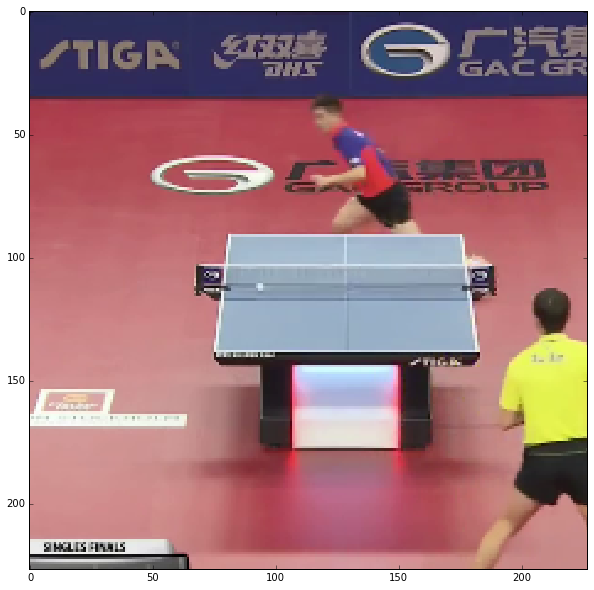

In [8]:
# print caffe.io.load_image(thesis_root + 'labeled_image_selected/bottom_player_winning_selected/point_00001_frame_00033.png').shape
# print caffe.io.load_image(thesis_root + 'labeled_image_selected/bottom_player_winning_selected/point_00001_frame_00033.png')[0][0]
# print training_set['data'][0][0][0]
start_time = time.time()

result = []
for pt_index in xrange(len(training_set['data'])):
#for pt_index in xrange(2):
    pt_result = []
    for frame_index in xrange(len(training_set['data'][pt_index])):
    #for frame_index in xrange(5):
        net.blobs['data'].data[...] = transformer.preprocess('data', training_set['data'][pt_index][frame_index])
        #net.blobs['data'].data[...] = map(lambda x: transformer.preprocess('data', x), training_set['data'][i:i+10])
        out = net.forward()
        #print net.blobs['fc7'].data.shape
        pt_result.append(np.mean(net.blobs['fc7'].data, axis=0))
    result.append(pt_result)

print 'Number of pts in result: ', len(result), 'Number of frame labels in result[0]', len(result[0])
print 'result[0][0]: ', result[0][0]

print 'Total time for neural net: ', time.time()-start_time, ' seconds'
print transformer.deprocess('data', net.blobs['data'].data[0]).shape
print 'Sample image from the training set'
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[4]))

In [9]:
#print np.max(result[0][0])
#print np.median(result[0][0])
print 'result length', len(result)
print 'training_set[target] length', len(training_set['target'])
print 'result[0] length', len(result[0])
print 'training_set[target][0] length', len(training_set['target'][0])

result length 1
training_set[target] length 1
result[0] length 115
training_set[target][0] length 115


In [10]:
output_file = './seq_data/point_%05d.dat'%(pt_index+1)
with open(output_file, 'w+') as f:
    for i in xrange(len(result[pt_index])):
        result_lst = [str(elem) for elem in result[pt_index][i]]
        f.write(' '.join(result_lst))
        f.write(' '+training_set['target'][pt_index][i])
        f.write('\n')
#print training_set['target'][0][0]
#print result[0][0]
print 'SAVE LABEL TO '+output_file